In [17]:
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio as rs
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.features import geometry_mask
from shapely.geometry import Point
from datetime import datetime
from sklearn.utils import resample
import sys
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../../src/')
from evaluation import validation as val
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prepare Stratified Sample

Details  
- type: pixel-based analysis
- design: stratified sampling approach by class
- total study area (all pixels in the strata): 26 districts
- total samples: when choosing sample count, consider how many points will be dropped from buffer zone and lack of ARD (when creating validation data).

Code: `src/evaluation/validation.py`  
visual inspo: https://github.com/sentinel-hub/eo-learn/blob/master/examples/land-cover-map/SI_LULC_pipeline.ipynb

In [19]:
final = '../../tmp/ghana/preds/mosaic/final_2024-10-29.tif'
outfile = f'../../data/validation/sampled_points.shp'
buffer = 1000
params_path = '../../params.yaml'

In [3]:
sampled_points = val.run_validation_workflow(final, 
                                             outfile,
                                             buffer,
                                             params_path)

Class distribution: {0: 267810570, 1: 1354277, 2: 151443764, 3: 86913627}
Class proportions: {0: 52.77, 1: 0.27, 2: 29.84, 3: 17.13}
Total count (pixels): 507522238
Creating buffer zone with ['v08', 'v14', 'v15', 'v19', 'v20', 'v21', 'v22', 'v23'] batches
Total_samples: 1067.0
Sampling 563 points for class 0 out of 264952720 available pixels.
Sampling 2 points for class 1 out of 1139546 available pixels.
Sampling 318 points for class 2 out of 148586138 available pixels.
Sampling 182 points for class 3 out of 85917262 available pixels.


# Gather additional validation points
To account for the samples labeled unknown, more validation points are required. Adds more monoculture samples as well as samples for all classes to account for dropped samples in round 1. This uses a manually assigned class proportion. These points should be cross referenced with the original batch to ensure no overlap. (or add something into the code to ensure this step happens).

In [17]:
js = pd.read_csv(f'../../data/validation/ceo-plantations-validation-jessica-sample-data-2024-11-27.csv')
js.System.value_counts()

No vegetation    417
Agroforestry     339
Natural          155
Unknown          147
Monoculture        4
Name: System, dtype: int64

In [18]:
js.shape

(1065, 14)

In [16]:
# which class do the unknowns primary fall into
unknown_samples = js[js.System == 'Unknown']['pl_pred']
unknown_samples.value_counts()

0    63
2    45
3    39
Name: pl_pred, dtype: int64

In [23]:
# looking at proportion of unknowns for each class, add
# {0: 40, 1: 50, 2: 50, 3: 60}
sampled_points = val.run_validation_workflow(final, 
                                             f'../../data/validation/sampled_points_v2.shp',
                                             buffer,
                                             params_path,
                                             valv1=f'../../data/validation/ceo-plantations-validation-jessica-plot-data-2024-11-27.csv',
                                             total_samples=200)

Class distribution: {0: 267810570, 1: 1354277, 2: 151443764, 3: 86913627}
Class proportions: {0: 52.77, 1: 0.27, 2: 29.84, 3: 17.13}
Total count (pixels): 507522238
Creating buffer zone with ['v08', 'v14', 'v15', 'v19', 'v20', 'v21', 'v22', 'v23'] batches
Total_samples: 200
Sampling 40 points for class 0 out of 246763275 available pixels.
Sampling 50 points for class 1 out of 1080596 available pixels.
Sampling 50 points for class 2 out of 138349526 available pixels.
Sampling 60 points for class 3 out of 79684828 available pixels.


# Identify non-consensus labels
In the consensus labeling approach, any labels that do not have agreement between 2 parties go to 3rd party review. This step sets up the CEO survey for the 3rd party.  
Requires the final sample csv from both parties.

In [8]:
def confirm_ready(df):
    df = df.rename(columns={"System": "system"})
    missing_values = df[df['system'].isna()]
    if len(missing_values) > 0:
        print(f"WARNING: There are {len(missing_values)} samples with no label. Review the CEO survey.")
        return None
    df = df[['plotid', 'system', 'lon', 'lat', 'pl_pred']]    
    return df

def determine_label(row):
    '''
    If system_jess == system_john, the function immediately returns the matching value.
    If system_jess is 'unknown', return system_john.
    If system_john is 'unknown', return system_jess.
    If neither of the above conditions is met, return 'nc'.
    '''
    if row['system_jess'] == row['system_john']:
        return row['system_jess']
    
    return row['system_john'] if row['system_jess'] == 'Unknown' else (
           row['system_jess'] if row['system_john'] == 'Unknown' else 'nc')
    
def non_consensus_survey(df1, df2):
    '''
    df1 must be jess
    df2 must be john
    Creates a csv with non-consensus plots for 3rd party labeling
    Creates a clean csv with consensus plots for validation
    '''
    df1 = confirm_ready(df1)
    df2 = confirm_ready(df2)
    
    consensus = df1.merge(df2[['plotid', 'system']], 
                      on='plotid', 
                      suffixes=('_jess', '_john'))
    
    # create final label column
    consensus['final_label'] = consensus.apply(determine_label, axis=1)
    
    non_consensus = consensus[consensus.final_label == 'nc']
    print("Total non-consensus rows:", len(non_consensus))
    non_consensus = non_consensus[['plotid', 'lon', 'lat']]

    # drop all rows marked unknown or nc
    # is this needed?
    # consensus = consensus[consensus.final_label != 'Unknown'].reset_index(drop=True)
    # consensus = consensus[consensus.final_label != 'nc'].reset_index(drop=True)
    # consensus = consensus[['plotid', 'lon', 'lat', 'final_label']]    

    non_consensus.to_csv('../../data/validation/non_consensus_labels_v2.csv')
    # consensus.to_csv('../../data/validation/consensus_labels_v2.csv')
    return consensus, non_consensus

In [40]:
john1 = pd.read_csv('../../data/validation/ceo-plantations-validation-john-sample-data-2025-01-09.csv')
jess1 = pd.read_csv('../../data/validation/ceo-plantations-validation-jessica-sample-data-2025-01-09.csv')
john2 = pd.read_csv('../../data/validation/ceo-plantations-validation2-john-sample-data-2024-12-17.csv')
jess2 = pd.read_csv('../../data/validation/ceo-plantations-validation2-jessica-sample-data-2024-12-17.csv')
daniel1 = pd.read_csv('../../data/validation/ceo-plantations-non-consensus2-sample-data-2025-01-17.csv')
daniel2 = pd.read_csv('../../data/validation/ceo-plantations-non-consensus1-sample-data-2025-01-13.csv')
john1.shape, jess1.shape, john2.shape, jess2.shape

((1065, 14), (1065, 14), (200, 14), (200, 14))

In [41]:
con, noncon = non_consensus_survey(jess1, john1)

Total non-consensus rows: 108


### Confusion Matrix [Non Consensus Labels]

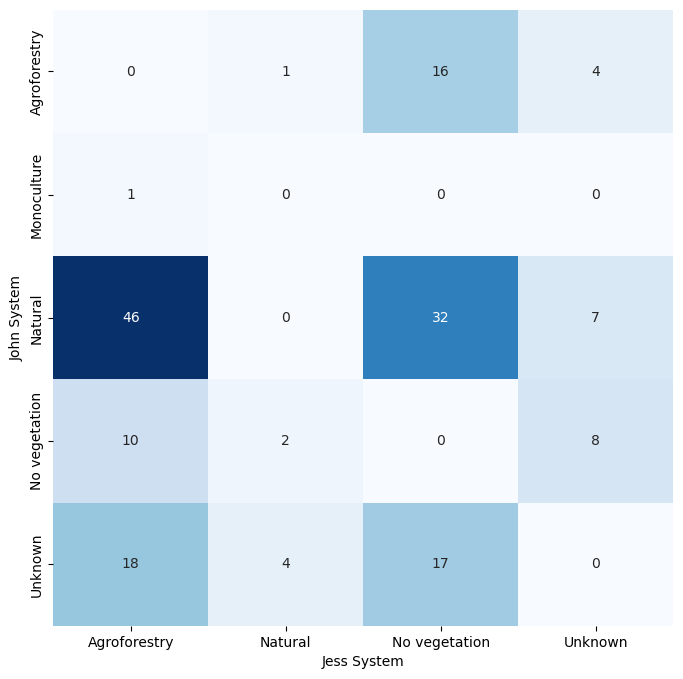

In [7]:
# early version
merge = john[['plotid', 'System']].merge(jess[['plotid', 'System']], on='plotid', suffixes=('_john', '_jess'))

non_matching = merge[merge['System_john'] != merge['System_jess']]
total_non_matching = non_matching.shape[0]
print("Total count of non-matching rows:", total_non_matching)

conf_matrix = pd.crosstab(non_matching['System_john'], non_matching['System_jess'], rownames=['John System'], colnames=['Jess System'])

plt.figure(figsize=(8,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.show()

# Integrate 3rd party labels
Integrates the 3rd party review into the original surveys to replace 'nc' labels.

In [42]:
def third_party_review(df1, df2, df3):
    '''
    df1 must be jess
    df2 must be john
    df3 must be daniel 
    Creates a csv that allocates daniel's labels to
    all plots where jess and john do not agree, based
    on the previous logic of defining consensus
    '''
    df1 = confirm_ready(df1)
    df2 = confirm_ready(df2)
    df3 = df3.rename(columns={"System": "system"})
    df3 = df3[['plotid', 'system', 'lon', 'lat']] 
    
    consensus = df1.merge(df2[['plotid', 'system', 'pl_pred']], 
                      on='plotid', 
                      suffixes=('_jess', '_john'))
    consensus['final_label'] = consensus.apply(determine_label, axis=1)

    # Create a mapping of plotid to system
    third_mapping = df3.set_index('plotid')['system']
    
    # incorporate 3rd party labels
    consensus.loc[consensus['final_label'] == 'nc', 'final_label'] = (
        consensus.loc[consensus['final_label'] == 'nc', 'plotid'].map(third_mapping)
    )
    assert 'nc' not in consensus['final_label'].values
    
    # clean up final output
    consensus = consensus[consensus.final_label != 'Unknown'].reset_index(drop=True)
    consensus = consensus.rename(columns={"final_label":"y_true",
                                         "pl_pred_jess": "y_pred"})
    pl_pred_map = {
        0: 'No vegetation',
        1: 'Monoculture',
        2: 'Agroforestry',
        3: 'Natural'}
    
    consensus['y_pred'] = consensus['y_pred'].map(pl_pred_map)
    consensus = consensus[['lon','lat','y_true', 'y_pred']]
    return consensus

In [43]:
round1 = third_party_review(jess1, john1, daniel1)
round2 = third_party_review(jess2, john2, daniel2)

In [44]:
stacked_df = pd.concat([round1, round2], ignore_index=True)
stacked_df.y_true.value_counts()

No vegetation    429
Agroforestry     426
Natural          250
Monoculture       16
Name: y_true, dtype: int64

In [64]:
stacked_df.shape

(1121, 4)

# Evaluate Model
Metrics:
- accuracy: overall assessment
- precision: how many predicted positives were correct?
- recall: how many true positives were identified?
- f1: overall measure of precision/recall
- ROC/AUC: how well does the model differentiate between classes?

In [63]:

from sklearn import metrics
predictions = stacked_df.y_pred
true_labels = stacked_df.y_true
class_names = list(set(true_labels))
class_labels = [0,1,2,3]

# Extract and display metrics
f1_scores = metrics.f1_score(true_labels, predictions, labels=class_names, average=None)
avg_f1_score = metrics.f1_score(true_labels, predictions, average="weighted")
recall = metrics.recall_score(true_labels, predictions, labels=class_names, average=None)
precision = metrics.precision_score(true_labels, predictions, labels=class_names, average=None)
accuracy = metrics.accuracy_score(true_labels, predictions)
#roc_auc = metrics.roc_auc_score(true_labels, predictions, labels=class_labels)

print("Classification accuracy {:.1f}%".format(100 * accuracy))
print("Classification F1-score {:.1f}%".format(100 * avg_f1_score))
# print("Classification AUC {:.1f}%".format(100 * accuracy))
print()
print("             Class              =  F1  | Recall | Precision")
print("         --------------------------------------------------")

results = []
for idx, lulctype in enumerate(class_names):
    f1, rec, prec = f1_scores[idx] * 100, recall[idx] * 100, precision[idx] * 100
    results.append([lulctype, f1, rec, prec])
    print("         * {0:20s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}".format(lulctype, f1, rec, prec))

results.append(["Overall", avg_f1_score * 100, "-", "-", accuracy * 100])
df_results = pd.DataFrame(results, columns=['Class', 'F1 Score (%)', 'Recall (%)', 'Precision (%)', 'Accuracy (%)'])
df_results['Run'] = pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S') 
outf = "../../data/validation/accuracy_assessment_log.csv"
df_results.to_csv(outf, mode='a', index=False, 
                  header=not pd.io.common.file_exists(outf))

Classification accuracy 66.1%
Classification F1-score 65.2%

             Class              =  F1  | Recall | Precision
         --------------------------------------------------
         * Monoculture          = 38.8 |  81.2  | 25.5
         * Agroforestry         = 60.5 |  53.3  | 69.8
         * Natural              = 51.3 |  46.0  | 58.1
         * No vegetation        = 79.1 |  90.0  | 70.6


### Confusion Matrix [Model Evaluation]

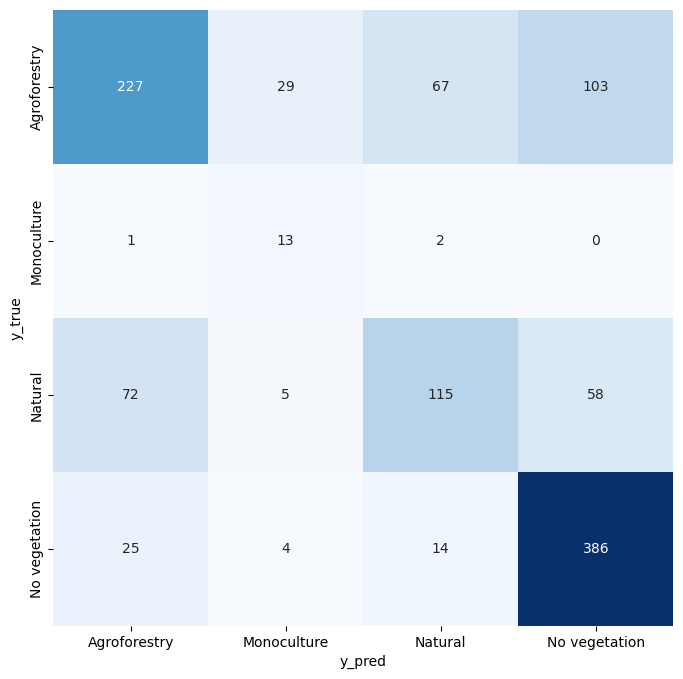

In [52]:
conf_matrix = pd.crosstab(stacked_df['y_true'], stacked_df['y_pred'], rownames=['y_true'], colnames=['y_pred'])

plt.figure(figsize=(8,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.show()

In [53]:
stacked_df[stacked_df.y_true == 'Monoculture']

,lon,lat,y_true,y_pred
512,-1.582874,5.528688,Monoculture,Monoculture
749,-0.902822,6.520598,Monoculture,Agroforestry
794,-0.667490,6.569950,Monoculture,Natural
795,-2.286761,9.214053,Monoculture,Natural
975,-2.334157,6.599616,Monoculture,Monoculture
978,-1.603959,5.731673,Monoculture,Monoculture
980,-1.651722,5.668476,Monoculture,Monoculture
981,-2.403922,6.395103,Monoculture,Monoculture
982,-1.473779,6.491112,Monoculture,Monoculture
983,-1.528051,5.561051,Monoculture,Monoculture


In [16]:
jess1

,plotid,sampleid,sample_internal_id,lon,lat,email,flagged,collection_time,analysis_duration,imagery_title,imagery_attributions,sample_geom,pl_pred,System
0,0,0,765151974,-2.071047,10.615168,jessica.ertel@wri.org,False,2024-11-07 19:40,99.7 secs,Mapbox Satellite,NaN,POINT(-2.071047378 10.61516803),0,No vegetation
1,1,1,765151975,-0.100567,6.578401,jessica.ertel@wri.org,False,2024-10-29 19:33,7.8 secs,Mapbox Satellite,NaN,POINT(-0.100566997 6.578400683),0,No vegetation
2,2,2,765151976,-0.827740,10.418476,jessica.ertel@wri.org,False,2024-10-29 19:33,23.9 secs,Mapbox Satellite,NaN,POINT(-0.827739714 10.4184762),0,Agroforestry
3,3,3,765151977,-0.488447,10.894204,jessica.ertel@wri.org,False,2024-10-29 19:34,47.2 secs,Mapbox Satellite,NaN,POINT(-0.488447451 10.89420435),0,No vegetation
4,4,4,765151978,-0.735697,10.335053,jessica.ertel@wri.org,False,2024-10-29 19:34,33.0 secs,Mapbox Satellite,NaN,POINT(-0.735697176 10.33505297),0,No vegetation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,1060,1060,765153034,-2.151905,9.618764,jessica.ertel@wri.org,False,2024-11-27 14:51,29.2 secs,Mapbox Satellite,NaN,POINT(-2.151905464 9.618763862),3,Natural
1061,1061,1061,765153035,-0.253666,7.022845,jessica.ertel@wri.org,False,2024-11-27 14:51,16.2 secs,Mapbox Satellite,NaN,POINT(-0.25366564 7.022845128),3,Unknown
1062,1062,1062,765153036,-2.169049,9.232122,jessica.ertel@wri.org,False,2024-11-27 14:52,14.9 secs,Mapbox Satellite,NaN,POINT(-2.169048845 9.232122366),3,Natural
1063,1063,1063,765153037,-2.281993,9.716391,jessica.ertel@wri.org,False,2024-11-27 14:52,16.1 secs,Mapbox Satellite,NaN,POINT(-2.281993473 9.716390615),3,Agroforestry


In [45]:
# things to check
# were there any situations where john, jess and dan disagree
df1 = confirm_ready(jess1)
df2 = confirm_ready(john1)
df3 = daniel1.rename(columns={"System": "system"})
df3 = df3[['plotid', 'system']] 
consensus = df1.merge(df2[['plotid', 'system', 'pl_pred']], 
                      on='plotid', 
                      suffixes=('_jess', '_john'))
consensus = consensus.merge(df3, 
                            on='plotid', 
                            how='left', 
                            suffixes=('', '_dan'))
consensus.rename(columns={'system': 'system_dan',
                         'pl_pred_jess':'pl_pred'}, inplace=True)
df = consensus[['plotid', 'pl_pred', 'system_jess','system_john', 'system_dan']]

In [46]:
df1 = confirm_ready(jess2)
df2 = confirm_ready(john2)
df3 = daniel2.rename(columns={"System": "system"})
df3 = df3[['plotid', 'system']] 
consensus = df1.merge(df2[['plotid', 'system', 'pl_pred']], 
                      on='plotid', 
                      suffixes=('_jess', '_john'))
consensus = consensus.merge(df3, 
                            on='plotid', 
                            how='left', 
                            suffixes=('', '_dan'))
consensus.rename(columns={'system': 'system_dan',
                         'pl_pred_jess':'pl_pred'}, inplace=True)
df2 = consensus[['plotid', 'pl_pred', 'system_jess','system_john', 'system_dan']]

In [47]:
a = df[~df.system_dan.isna()]
a = a[
    (df['system_jess'] != df['system_john']) &
    (df['system_jess'] != df['system_dan']) &
    (df['system_john'] != df['system_dan'])
]

/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_7038/546030841.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  a = a[


In [48]:
a

,plotid,pl_pred,system_jess,system_john,system_dan
34,34,0,No vegetation,Natural,Agroforestry
39,39,0,No vegetation,Natural,Agroforestry
54,54,0,Agroforestry,No vegetation,Natural
55,55,0,No vegetation,Natural,Agroforestry
58,58,0,No vegetation,Agroforestry,Natural
69,69,0,No vegetation,Natural,Agroforestry
94,94,0,Natural,No vegetation,Agroforestry
117,117,0,No vegetation,Natural,Agroforestry
119,119,0,No vegetation,Natural,Agroforestry
146,146,0,No vegetation,Natural,Agroforestry


In [49]:
len(a)

22

In [50]:
# what were the labels for all the monoculture classes
df[df.pl_pred == 1]

,plotid,pl_pred,system_jess,system_john,system_dan
563,563,1,Agroforestry,Agroforestry,NaN
564,564,1,Monoculture,Monoculture,NaN


In [51]:
df2[df2.pl_pred == 1]

,plotid,pl_pred,system_jess,system_john,system_dan
40,40,1,Agroforestry,Agroforestry,NaN
41,41,1,Agroforestry,Agroforestry,NaN
42,42,1,Monoculture,Monoculture,NaN
43,43,1,No vegetation,No vegetation,NaN
44,44,1,Agroforestry,Agroforestry,NaN
45,45,1,Monoculture,Monoculture,NaN
46,46,1,Agroforestry,Agroforestry,NaN
47,47,1,Monoculture,Monoculture,NaN
48,48,1,Monoculture,Monoculture,NaN
49,49,1,Monoculture,Monoculture,NaN


# Other Exercises

In [2]:
# create a comb mosaic
def mosaic_tif(tifs_to_mosaic, outpath):

    ''''
    Takes in a list of raster files and
    merges them to form a single tif.

    '''
    dir = f'../../tmp/ghana/preds/mosaic/'
    reader_mode = []

    for file in tifs_to_mosaic:
        src = rs.open(dir+file)
        reader_mode.append(src) 
    print(f'Merging {len(reader_mode)} tifs.')

    mosaic, out_transform = merge(reader_mode)
    date = datetime.today().strftime('%Y-%m-%d')
    outpath = f"{dir}{outpath}_{date}.tif"
    out_meta = src.meta.copy()  
    out_meta.update({'driver': "GTiff",
                     'dtype': 'uint8',
                     'height': mosaic.shape[1],
                     'width': mosaic.shape[2],
                     'transform': out_transform,
                     'compress':'lzw',
                     'nodata': 255})

    with rs.open(outpath, "w", **out_meta) as dest:
        dest.write(mosaic)

    # Ensure to close all files
    for src in reader_mode:
        src.close()

    return None

In [3]:
tifs = ['pd_north_FINAL.tif',
        'pd_east_FINAL.tif',
        'pd_west_FINAL.tif',
       ]

mosaic_tif(tifs, 'final')

Merging 3 tifs.


In [ ]:
## legacy code

In [80]:
# confirm the AOI with 3 different methods
# land_use_map.size	
# Very fast, direct access to array size	
# Includes 255 and other invalid values in the count
# Getting the total number of pixels

# np.bincount()
# Efficiently counts only specified valid classes
# Limited by minlength, ignores other valid classes	
# If you know exactly which classes to count

# Conditional sum()	
# Counts all pixels except 255, flexible
# Slower and more memory-intensive for large datasets
# When you want to exclude 255 without specifying valid classes

counts = np.bincount(land_use_map.flatten(), minlength=4) 
classes = [0, 1, 2, 3] 
valid_counts = counts[classes]
total_count = valid_counts.sum()
lulc_count = sum(land_use_map[land_use_map != 255])

print(land_use_map.size)
print(total_count)
print(lulc_count)